In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#gan (적대적 신경망)

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# 생성자 모델 (generator)

generator=Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
#128: 임의의 노드 수, 7*7 upsampling >> 14*14 >> 28*28
#input_dim : 임의의 100차원 크기 random vector 준비해서 집어 넣겠다
#activation=LeakyReLU(0,2) : 0 보다 작을 경우 0.2 곱해서 출력
generator.add(BatchNormalization())
#배치정규화 : 입력 데이터를 평균은 0, 분산은 1이 되게 재배치
generator.add(Reshape((7,7,128))) #컨볼루션 레이어가 받아들일 수 있는 형태로 변환 Conv2D함수의 input_shape 부분에 들어갈 형태로 정함
generator.add(UpSampling2D()) #14*14로 변환 자동으로 2배 디폴트로 되어있음
generator.add(Conv2D(64, kernel_size=5, padding='same'))
#5*5 filter(kernel)사용, padding='same' 모자라는 부분 자동으로 0 채워짐
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
#LeakyReLU 렐루함수에서 x값이 음수이면 무조건 0이 되어 뉴런들이 일찍 소실되는 단점 보완을 위해 0 이하에서도 작은 값을 만들기
generator.add(UpSampling2D()) #28*28
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
#tanh -1~1 사이로 출력

위 코드는 Keras를 사용하여 생성자(generator) 모델을 정의하는 코드입니다. 생성자 모델은 무작위 잡음 벡터를 입력으로 받아 가짜 이미지를 생성하는 역할을 합니다.


- 첫 번째 레이어는 100차원의 무작위 잡음 벡터를 입력으로 받아 128 x 7 x 7 크기의 텐서를 출력합니다. 활성화 함수로는 LeakyReLU 함수를 사용하며, 이 함수는 입력값이 0보다 작을 경우에는 약간의 기울기를 가진 직선 함수를 반환합니다. 이를 통해 입력값이 0보다 작아도 소실되지 않고 정보를 전달할 수 있도록 합니다.

- BatchNormalization 레이어는 입력값을 정규화하여 평균을 0, 분산을 1로 만듭니다. 이를 통해 학습이 더욱 안정적으로 이루어지도록 하고, 과적합을 방지할 수 있습니다.

- Reshape 레이어는 이전 레이어에서 출력된 128 x 7 x 7 크기의 텐서를 7 x 7 x 128 크기의 텐서로 변환합니다.

- UpSampling2D 레이어는 텐서의 크기를 두 배로 늘립니다. 이후 Conv2D 레이어를 사용해 이미지의 크기를 키워나갑니다. kernel_size=5는 필터(커널)의 크기를 5 x 5로 설정한 것입니다.

- 마지막 Conv2D 레이어는 1개의 채널(흑백 이미지)을 출력하며, 활성화 함수로는 tanh 함수를 사용합니다. tanh 함수는 출력값을 -1과 1 사이로 조정합니다. 이를 통해 생성된 가짜 이미지를 흑백 이미지로 만듭니다.

즉, 위 코드는 100차원의 무작위 벡터를 입력으로 받아 28 x 28 크기의 흑백 가짜 이미지를 생성하는 생성자(generator) 모델을 정의하는 코드입니다.

In [7]:
# 판별자 (discriminator)

#--Feature Extraction (특징 추출) -- 
discriminator=Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same'))
#strides=2 > 커널 윈도 2칸 씩 움직임 > 드롭아웃이나 pooling 과정 대체(새로운 필터 적용 효과) > 가로/세로 크기가 더 줄어들어 새로운 특징 추출 효과
#생성자에서는 출력 수를 28로 맞춰여해서 오히려 업샘플링을 통해 가로세로 크기 늘려주었지만 판별자는 진짜 가짜만 구분하면 되기 때문에 필요 x
#커널 크기 5로 설정해 5x5 커널 사용됨을 알 수 있음
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
#-----------------------------------------
discriminator.add(Flatten()) #2차원 > 1차원
discriminator.add(Dense(1, activation='sigmoid'))  #sigmoid 판별자 진자 혹은 가짜 둘 중 하나라 시그모이드
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable=False
#판별자 자신이 학습되지 않게 학습 기능 꺼줌 (매우 중요)

In [9]:
#gan network (생성자와 판별자 모델 연결)

ginput=Input(shape=(100, )) #무작위로 100개의 벡터 집어 넣음 생성자에 입력할 ginput 만드는 과정
dis_output=discriminator(generator(ginput)) 
#생성된 28*28 이미지 판별자의 입력값 들어감 ginput 노이즈가 들어감 판별자ㅏ는 이거 가지고 참 거짓 판별 이것을 dis_output
gan=Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
#참 거짓 분류(이진 분류)

gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


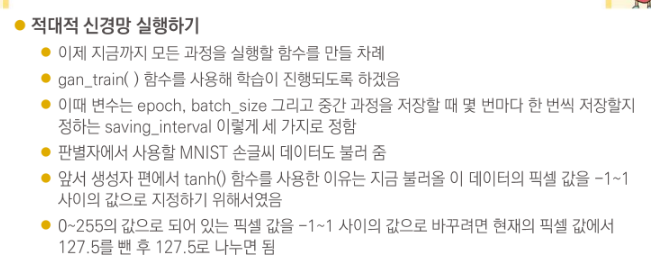

In [15]:
#신경망을 실행시키는 함수 만들기

def gan_train(epoch, batch_size, saving_interval):
    (x_train, _), (_,_) = mnist.load_data()
    #테스트 과정은 필요 없고 이미지만 사용할 것이기 떄문에 x train 만 호출

    x_train=x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
    #가로 28 세로 28 픽셀이고 흑백이므로 1 설정 
    # (이미지 개수, 높이, 너비)에서 (이미지 개수, 높이, 너비, 채널)로 변경

    x_train=(x_train - 127.5) / 127.5
    #픽셀 값 : 0~255 사이 값
    #이전에 255로 나누어 줄 때는 이를 0~1 사이의 값으로 바꾸었던 것임
    #127.5를 뺀 후, 127.5로 나누면 -1 ~ 1 사이 값으로 바뀜

    #batch_size : 한 번에 몇 개의 실제 이미지와 가상 이미지를 판별자에게 넣을 지 결정
    true=np.ones((batch_size, 1)) #모두 참인 배열 생성
    fake=np.zeros((batch_size, 1))

    for i in range(epoch): 
        #실제 데이터를 판별자에 입력하는 부분
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        #실제 이미지를 무작위하게 선택, 불러옴
        #~randint(a,b,c) a부터 b까지 수를 하나를 랜덤 선택해 가져오는 과정을 c번 반복 
        #0부터 x_train.shape[0]까지 숫자 중 하나를 무작위 추출, 배치사이즈만큼 반복
        imgs=x_train[idx] #선택된 숫자에 해당하는 이미지 불러오기
        d_loss_real = discriminator.train_on_batch(imgs, true) #train_on_batch(imgs, true) 입력 값 x 레이블 y를 받아서 딱 한 번 학습을 실시해 모델 업데이트
        #생성한 이미지와 모두 참(1)인 true 배열 y에 놓음
        #여기서 차이가 발생하면 loss (손실)

        #가상 이미지를 판별자에 입력하는 부분
        noise=np.random.normal(0,1, (batch_size, 100))
        #생성장에 넣을 가상 이미지 생성 > noise
        #정수가 아니기 때문에 정규분포 형태로 만들어줌
        #0~1까지 batcj_size만큼 100열 뽑음

        gan_imgs = generator.predict(noise)
        #노이즈(생성된 가상 이미지)가 생성자에 입력(예측), 결과값이 gan_imgs 로 저장
        d_loss_fake = discriminator.train_on_batch(gan_imgs, fake)
        #만들어진 가짜 이미지(gan_imgs)에 fake배열(모두 0)레이블이 붙음

        #판별자와 생성자의 오차 계싼
        #d_loss_real, d_loss_fake 값을 더해서 둘로 나눈 평균 > 판별자의 오차
        d_loss=0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss=gan.train_on_batch(noise, true) #생성자의 오차

        print('epoch : %d'%i, ' d_loss : %.4f' %d_loss, ' g_loss : %.4f' %g_loss)

        if i % saving_interval == 0:
            #r, c = 5, 5
            noise = np.random.normal(0,1,(25,100))
            gan_imgs = generator.predict(noise)

            # rescale imgs 0~1
            gan_imgs = 0.5 * gan_imgs + 0.5

            fig, axs = plt.subplots(5,5)
            count=0
            for j in range(5):
                for k in range(5):
                    axs[j,k].imshow(gan_imgs[count, :, :, 0], cmap='gray')
                    axs[j,k].axis('off')
                    count += 1
                fig.savefig('/content/drive/MyDrive/sesac_ai/code/deeplearning/data/gan_images/gan_mnist_new_%d.png'%i)


1/1 [==============================] - 0s 18ms/step
epoch : 0  d_loss : 0.4483  g_loss : 0.0529
1/1 [==============================] - 0s 34ms/step
epoch : 1  d_loss : 0.4885  g_loss : 0.0262
1/1 [==============================] - 0s 25ms/step
epoch : 2  d_loss : 0.5030  g_loss : 0.0420
1/1 [==============================] - 0s 26ms/step
epoch : 3  d_loss : 0.4636  g_loss : 0.1077
1/1 [==============================] - 0s 26ms/step
epoch : 4  d_loss : 0.4373  g_loss : 0.2609
1/1 [==============================] - 0s 30ms/step
epoch : 5  d_loss : 0.4407  g_loss : 0.3769
1/1 [==============================] - 0s 50ms/step
epoch : 6  d_loss : 0.4630  g_loss : 0.3630
1/1 [==============================] - 0s 27ms/step
epoch : 7  d_loss : 0.4604  g_loss : 0.2929
1/1 [==============================] - 0s 28ms/step
epoch : 8  d_loss : 0.4278  g_loss : 0.2766
1/1 [==============================] - 0s 26ms/step
epoch : 9  d_loss : 0.4096  g_loss : 0.2672
1/1 [==============================] - 0

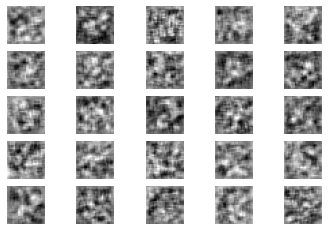

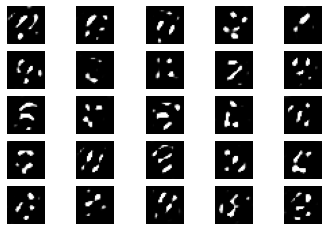

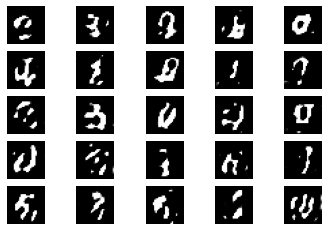

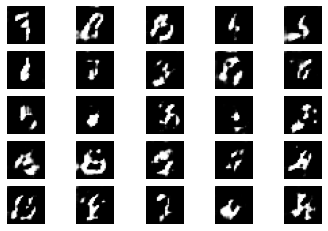

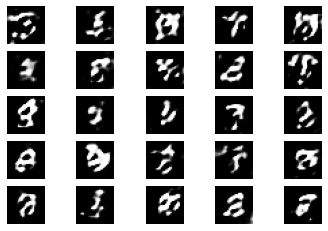

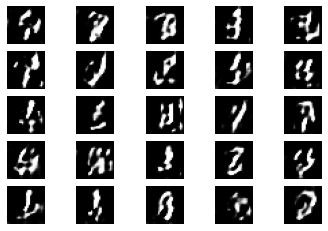

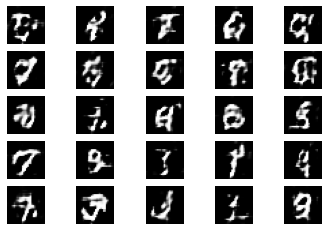

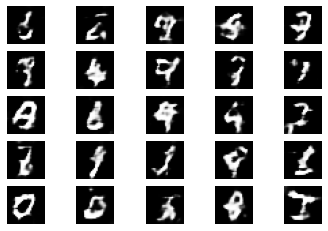

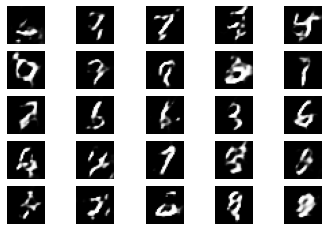

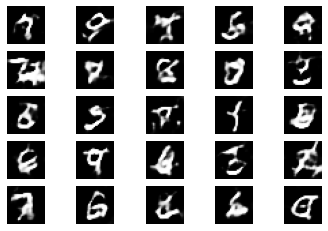

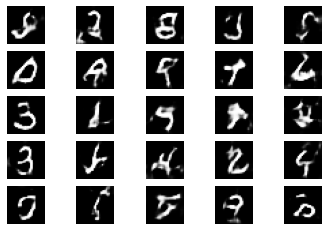

In [16]:
gan_train(2001, 32, 200)
#2000번 반복, batch_size=32 200번 마다 결과 저장